In [4]:
import matplotlib.pyplot as plt
import numpy as np
import types # used to re-define force

from mpl_toolkits.mplot3d.axes3d import Axes3D

%matplotlib inline

# Chapter 2: Kinematics

In [5]:
class TimeValue:
    def __init__(self, time, value):
        self.time = time * 1.0
        self.value = value * 1.0

    def __repr__(self):
        return '({}, {})'.format(self.time, self.value)

In [6]:
class TimeSeries:
    def __init__(self, points=[]):
        self.series = []
        for (time, value) in points:
            self.append(time, value)
        
    def append(self, time, value):
        self.series.append(TimeValue(time, value))
        self.series = sorted(self.series, key=lambda x: x.time)
        
    @property
    def initial(self):
        return self.series[0]
    
    @property
    def timeline(self):
        return [x.time for x in self.series]
    
    @property
    def values(self):
        return [x.value for x in self.series]
    
    @property
    def components(self, i=None):
        try:
            return list(zip(*self.values))
        except:
            return [self.values]

    def plot(self, toggle='0', title='', legend_loc='best', grid=True, marker=None, labels=None):
        if len(self.components) > 1:
            plt.plot(self.timeline, self.values, marker=marker)
            if legend_loc:
                plt.legend(['x','y','z'][:len(self.components)], loc=legend_loc, numpoints=1)
        else:
            r = self
            v = r.rate_of_change()
            a = v.rate_of_change()
            
            if '0' in toggle:
                plt.plot(r.timeline, r.values, marker=marker, label='position')
            if '1' in toggle:
                plt.plot(v.timeline, v.values, marker=marker, label='velocity')
            if '2' in toggle:
                plt.plot(a.timeline, a.values, marker=marker, label='acceleration')
            if legend_loc:
                if labels:
                    plt.legend(labels, loc=legend_loc, numpoints=1)
                else:
                    plt.legend(loc=legend_loc, numpoints=1)
        plt.title(title)
        plt.xlabel('Time')
        plt.margins(0.05)
        dt = 0.03 * (self.timeline[-1] - self.timeline[0])
        plt.axes().set_xlim([self.timeline[0] - dt, self.timeline[-1] + dt])
        if grid:
            plt.axes().axhline(0, c='k')
            plt.grid(True)

        
    def plot2d(self, x_index=0, y_index=1, toggle='0', title='',
               grid=True, legend_loc='lower left', markevery=0, arrows=False):
        
        r = self
        rx = r.components[x_index]
        ry = r.components[y_index]

        v = r.rate_of_change()
        vx = v.components[x_index]
        vy = v.components[y_index]

        a = v.rate_of_change()
        ax = a.components[x_index]
        ay = a.components[y_index]
        
        r_color, v_color, a_color = 'bgr'

        if '0' in toggle:
            plt.plot(rx, ry, c=r_color, label='position', 
                     markevery=[-1], marker='o', mfc='w', mec=r_color, mew=1)
            if markevery:
                plt.plot(rx, ry, lw=0, markevery=markevery, marker='.', mec=r_color)

        if '1' in toggle:
            plt.plot(vx, vy, c=v_color, label='velocity',
                     markevery=[-1], marker='o', mfc='w', mec=v_color, mew=1)            
            if markevery:
                plt.plot(vx, vy, lw=0, markevery=markevery, marker='.', mec=v_color)

        if '2' in toggle:
            plt.plot(ax, ay, c=a_color, label='acceleration', 
                     markevery=[-1], marker='o', mfc='w', mec=a_color, mew=1)
            if markevery:
                plt.plot(ax, ay, lw=0, markevery=markevery, marker='.', mec=a_color)
            
        plt.axes().set_aspect('equal')
        plt.margins(0.05)
        if legend_loc and len(toggle) > 1:
            plt.legend(numpoints=1, loc=legend_loc)
        plt.title(title)
        
        if grid:
            plt.axes().axhline(0, c='k')
            plt.axes().axvline(0, c='k')
            plt.grid(True)

        if arrows:
            xmin, xmax = plt.xlim()
            ymin, ymax = plt.ylim()
            size = 0.5 * (xmax - xmin) + 0.5 * (ymax - ymin)
            head_size = {
                'head_width': 0.03 * size,
                'head_length': 0.05 * size,
            }
            if '1' in toggle:
                plt.axes().arrow(rx[-1], ry[-1], vx[-1], vy[-1], 
                                 fc=v_color, ec=v_color, **head_size)
            if '2' in toggle:
                plt.axes().arrow(rx[-1], ry[-1], ax[-1], ay[-1], 
                                 fc=a_color, ec=a_color, **head_size)
             
    @property
    def intervals(self):
        intervals = []
        for i in range(1, len(self.series)):
            intervals.append((self.series[i - 1], self.series[i]))
        return intervals    
 
    def get_interval(self, time): # closed on left [a, b)
        tmin = min(self.timeline)
        tmax = max(self.timeline)
        if time < tmin:
            return None, self.series[0]
        elif time >= tmax:
            return self.series[-1], None
        else:
            for a, b in self.intervals:
                if a.time <= time and time < b.time:
                    return a, b
    
    def rate_of_change(self):
        ts = TimeSeries()
        for i, (a, b) in enumerate(self.intervals):
            dx = b.value - a.value
            dt = b.time - a.time
            if 1 == 0:
                ts.append(a.time, dx/dt)
            else:
                ts.append(a.time + dt/2, dx/dt)
        return ts
                
    def __call__(self, time):
        a, b = self.get_interval(time)
        # this method will not extrapolate, but we do need to take care of this edge case...
        if b is None and round(a.time - time, 10) == 0:
            return a.value
        else:
            dx = b.value - a.value
            dt = b.time - a.time
            return a.value + dx/dt * (time - a.time)
        
    def __repr__(self):
        import pprint
        return pprint.pformat(self.series)


**Free fall motion (no air drag)**

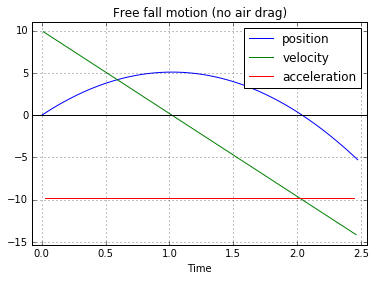

In [7]:
y = TimeSeries()
for i in range(100):
    t = i/40
    y.append(t, 10*t-4.9*t**2)
y.plot(title='Free fall motion (no air drag)',toggle='012')

**Uniform circular motion**

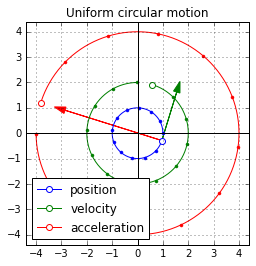

In [8]:
r = TimeSeries()
for q in range(600):
    t = q / 100
    x = 1.0 * np.cos(t)
    y = 1.0 * np.sin(t)
    r.append(0.5 * t, np.array([x,y]))
r.plot2d(title='Uniform circular motion', toggle='012', markevery=50, arrows=True)

**The components of UCM are SHM**

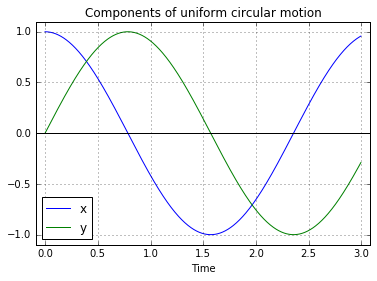

In [9]:
r.plot(title='Components of uniform circular motion')

# Chapter 4: Dynamics

In [10]:
class RigidObject():
    def __init__(self, mass=1, t0=0, r0=0, p0=0, v0=None):
        self.mass = mass
        self.position = TimeSeries([(t0, r0)])
        if self.mass and v0 is not None:
            self.momentum = TimeSeries([(t0, self.mass * v0)])
        else:
            self.momentum = TimeSeries([(t0, p0)])

    def netforce(self, time): # momentum flow or rate of change
        return 0

    def velocity(self, time): # position flow or rate of change
        if time > max(self.momentum.timeline):
            time = max(self.momentum.timeline)
        return self.momentum(time) / self.mass
    
    def increment(self, dt, n=1):
        for i in range(n):
            t = max(self.position.timeline)

            if len(self.position.timeline) == 1: # then only go forward half an increment            
                next_p = self.momentum(t) + self.netforce(t) * dt/2
                self.momentum = TimeSeries() # throw out that "initial" value
            else: # reach back half an increment to calculate the new momentum value
                next_p = self.momentum(t - dt/2) + self.netforce(t) * dt

            self.momentum.append(t + dt/2, next_p)
            next_r = self.position(t) + self.velocity(t + dt/2) * dt        
            self.position.append(t + dt, next_r)

**Confirm calculation on free fall trajectory**

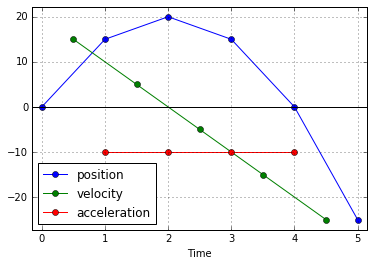

In [11]:
obj = RigidObject(v0=20)
obj.netforce = lambda t: -10
obj.increment(1, 5)
obj.position.plot(toggle='012', marker='o')

**Damped Harmonic Motion**

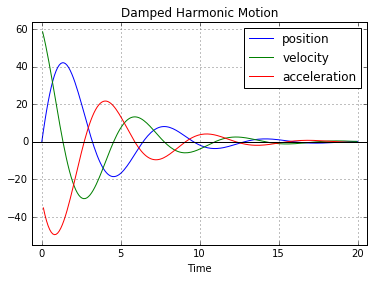

In [12]:
obj = RigidObject(v0=60)
obj.netforce = lambda t: -obj.position(t) - 0.5 * obj.velocity(t)
obj.increment(0.1, 200)
obj.position.plot('012', marker=None, title='Damped Harmonic Motion')

**Projectile motion with air drag**

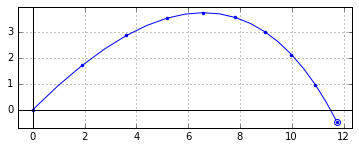

In [13]:
obj = RigidObject(t0=0, r0=np.array([0,0]), v0=np.array([10,10]))
obj.netforce = lambda t: np.array([0,-9.8]) - 0.5 * obj.velocity(t)
obj.increment(0.1, 18)
obj.position.plot2d(markevery=2)

**Uniform circular motion**

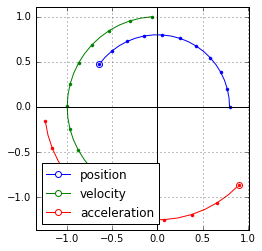

In [14]:
obj = RigidObject(t0=0, r0=np.array([0.8,0]), v0=np.array([0,1]))

def netforce(self, time):
    rx, ry = self.position(time)
    vx, vy = self.velocity(time)
    rmag2 = rx ** 2 + ry ** 2
    vmag2 = vx ** 2 + vy ** 2
    return -self.mass * np.array([rx, ry]) * vmag2 / rmag2
        
obj.netforce = types.MethodType(netforce, obj)
obj.increment(dt=0.1, n=20)
obj.position.plot2d(toggle='012', markevery=2)

**Newton's law of gravity**

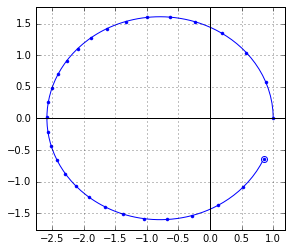

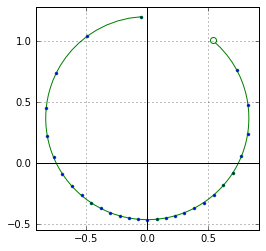

In [15]:
obj = RigidObject(t0=0, r0=np.array([1,0]), v0=np.array([0,1.2]))

def netforce(self, time):
    x, y = self.position(time)
    d = np.sqrt( x ** 2 + y ** 2 )
    return -np.array([x,y]) / d ** 3

obj.netforce = types.MethodType(netforce, obj)
obj.increment(dt=0.1, n=145)
plt.figure()
obj.position.plot2d(toggle='0', markevery=5)
plt.figure()
obj.position.plot2d(toggle='1', markevery=5)

**Newton's law of gravity in 3D**

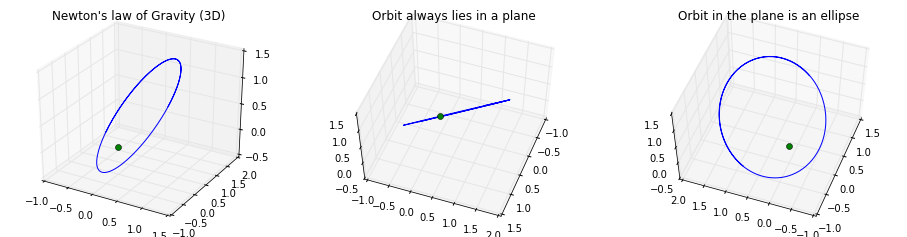

In [16]:
obj = RigidObject(t0=0, r0=np.array([1,0,1]), v0=np.array([0.1,0.6,0.5]))

def netforce(self, time):
    x, y, z = self.position(time)
    d = np.sqrt( x ** 2 + y ** 2 + z ** 2 )
    return -np.array([x,y,z]) / d ** 3

obj.netforce = types.MethodType(netforce, obj)
obj.increment(dt=0.05, n=300)

rx, ry, rz = obj.position.components

fig = plt.figure(figsize=plt.figaspect(0.25))

ax = fig.add_subplot(1, 3, 1, projection='3d')
ax.plot(rx, ry, rz)
ax.plot([0],[0],[0], marker='o')
plt.title("Newton's law of Gravity (3D)")

ax = fig.add_subplot(1, 3, 2, projection='3d')
ax.plot(rx, ry, rz)
ax.view_init(elev=57, azim=20)
ax.plot([0],[0],[0], marker='o')
plt.title("Orbit always lies in a plane")

ax = fig.add_subplot(1, 3, 3, projection='3d')
ax.plot(rx, ry, rz)
ax.view_init(elev=57, azim=200)
ax.plot([0],[0],[0], marker='o')
plt.title("Orbit in the plane is an ellipse")

**Rutherford scattering**

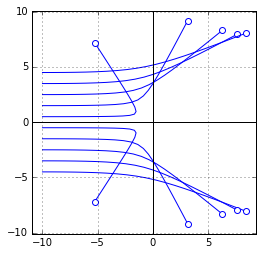

In [38]:
def netforce(self, time):
    x, y = self.position(time)
    d = np.sqrt( x ** 2 + y ** 2 )
    return np.array([x,y]) / d ** 3

for i in range(-5, 5):
    obj = RigidObject(t0=0, r0=np.array([-10,i+0.5]), v0=np.array([1,0]))
    obj.netforce = types.MethodType(netforce, obj)
    obj.increment(dt=1, n=20)
    obj.position.plot2d()

# Chapter 7: Interaction and Collisions

In [40]:
class PhysicalSystem:
    def __init__(self, parts=[]):
        for part in parts:
            assert isinstance(part, RigidObject)
        self.parts = parts
        
    def part(self, i): # simple wrapper
        return parts[i]